In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from SyncRNG import SyncRNG
import patsy
%matplotlib inline
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pyreadr
import seaborn as sns
import random
import string
import warnings
warnings.filterwarnings('ignore')

This notebook is based on Topic 3 of Susan Athey and Stefan Wager's course “MGTECON 634: Machine Learning and Causal Inference” (https://d2cml-ai.github.io/mgtecon634_py/md/intro.html#)

Data comes from the "General Social Survey" (https://gss.norc.org/Documents/reports/project-reports/GSSProject%20report32.pdf).

__Setting:__ randomized control trial

__Treatment (W):__ wording of a question: "welfare" (W==1) vs "assistince to the poor" (W==0)

__Outcome (Y):__ Support (Y==1) or Opposition (Y==0) to question

__Covariates (X):__ age, political views, income, education, marital status, sex

We seek to test whether the wording of a question has a causal effect on responses. 


In [2]:
# Read in data
# data = pd.read_csv( "https://docs.google.com/uc?id=1kSxrVci_EUcSr_Lg1JKk1l7Xd5I9zfRC&export=download" )
# data.to_pickle("gss.pkl")
data = pd.read_pickle("gss.pkl")
n = data.shape[0]

# Treatment: does the the gov't spend too much on "welfare" (1) or "assistance to the poor" (0)
treatment = "w"

# Outcome: 1 for 'yes', 0 for 'no'
outcome = "y"

# Additional covariates
covariates = ["age", "polviews", "income", "educ", "marital", "sex"]


Y = data.loc[:,outcome].copy()
W = data.loc[:,treatment].copy()
X = data.loc[:,covariates].copy()

n1 = (W==1).sum()
n0 = (W==0).sum()

n=n0+n1

print(n0,n1,n)

13337 15316 28653


In [3]:
def diff_in_means(Y,W):
    #sample means
    m1 = Y[W==1].mean()
    m0 = Y[W==0].mean()
    
    #sample variances
    s1 = Y[W==1].var()
    s0 = Y[W==0].var()
    
    #sample sizes
    n1 = (W==1).sum()
    n0 = (W==0).sum()
    
    ate_est = m1-m0
    ate_se = np.sqrt(s1/n1 + s0/n0)
    ate_tstat = ate_est/ate_se
    ate_pvalue = 2*norm.cdf(1-abs(ate_est/ate_se))
    
    return pd.DataFrame({'estimate': [ate_est],
                        'std_error': [ate_se],
                        't_stat': [ate_tstat],
                        'pvalue': [ ate_pvalue]})

In [4]:
diff_in_means(Y,W)

,estimate,std_error,t_stat,pvalue
0,-0.347116,0.004896,-70.903029,0.0


The difference-in-means estimator for the effect of the treatment is -0.347116. This suggests that individuals presented with the wording "welfare" tended to be less supportive than those presented with the wording "assistance to the poor."

Because this was a randomized experiment, the results are unconfounded in expectation. So it is reasonable to infer that the change in wording is the cause of this difference. While the results are unconfounded in expectation, that does not mean that the observed effect is unconfounded. While we can never test for confounding with unobserved quantities, we can check for confounding in the observed variables by estimating covariate __balance__. Intuitively, covariate balance corresponds to the "all else equal" assumption. If there is a significant difference between the treatment groups, __all else equal__, it is reasonable to infer that the treatment caused the difference. Of course, if all else is not equal, that is, if the covariate distributions are not balanced, we have no way to discern whether it was the treatment or the difference in covariates that caused the observed effect. 

Here, we directly test for equality of distribution between the two groups using a permutation test based on the 2-sample Energy Statistic. (See: Székely, Gábor J., and Maria L. Rizzo. "Energy statistics: A class of statistics based on distances.")

For more on balance, with many references, see https://cran.r-project.org/web/packages/cobalt/vignettes/cobalt.html

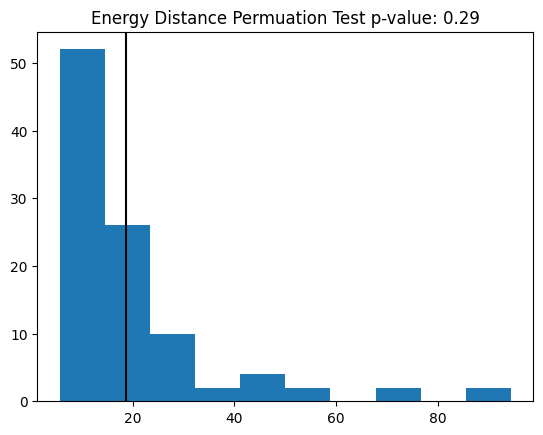

In [5]:
from scipy.spatial.distance import pdist,squareform

num_perm=100
num_subsample=2000

n0_temp = sum(W[:num_subsample]==0)
n1_temp=sum(W[:num_subsample]==1)

#Calculate Distance matrix (for first 2000 entries)
D = squareform(pdist(X[:num_subsample]))

#Calculate Observered Energy Distance between samples
E_obs = (n0_temp*n1_temp)/(n0_temp+n1_temp) * ( 2*(np.sum(D[W[:num_subsample]==1][:,W[:num_subsample]==0])/(n0_temp*n1_temp)) - (np.sum(D[W[:num_subsample]==0][:,W[:num_subsample]==0])/np.square(n0_temp)) - (np.sum(D[W[:num_subsample]==1][:,W[:num_subsample]==1])/np.square(n1_temp)))

E_permutations = np.zeros(num_perm)

#Sample from Distribution of Statistic
for i in range(num_perm):
    permutation = np.random.choice(num_subsample,num_subsample,replace=False)
    D_permute = D[permutation][:,permutation]
    E_permutations[i] = (n0_temp*n1_temp)/(n0_temp+n1_temp) *  (2*(np.sum(D_permute[W[:num_subsample]==1][:,W[:num_subsample]==0])/(n0_temp*n1_temp)) - (np.sum(D_permute[W[:num_subsample]==0][:,W[:num_subsample]==0])/np.square(n0_temp)) - (np.sum(D_permute[W[:num_subsample]==1][:,W[:num_subsample]==1])/np.square(n1_temp)))

plt.hist(E_permutations)
plt.axvline(E_obs,c='black')
plt.title("Energy Distance Permuation Test p-value: "+str(np.mean(E_obs<=E_permutations)))
plt.show()

We fail to reject the null hypothesis of equal distributions. 

It's also pretty clear just from looking at the histograms;

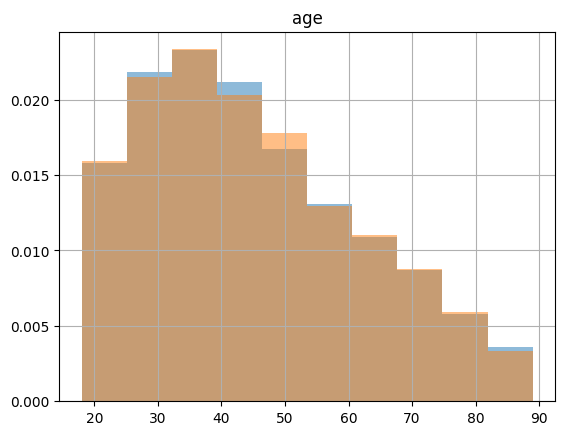

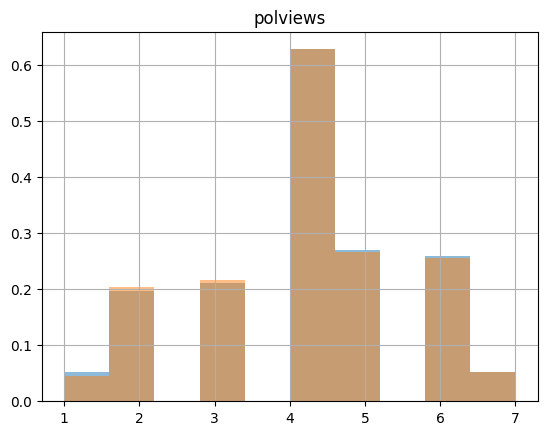

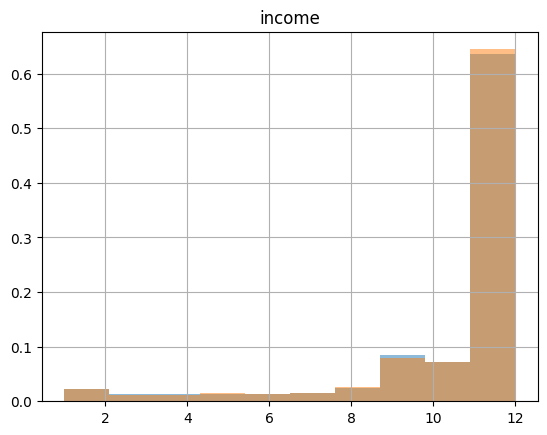

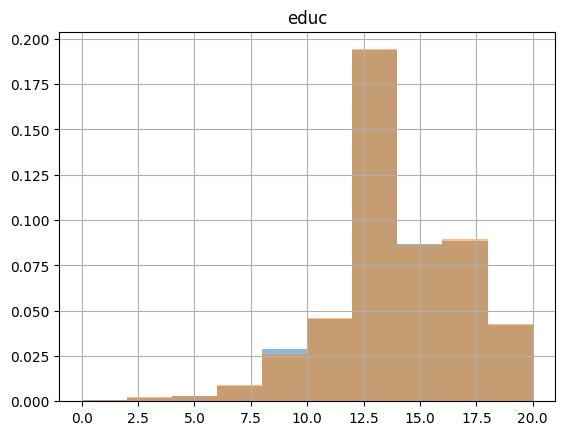

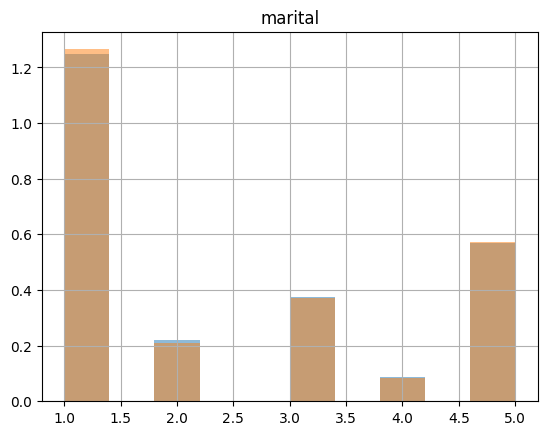

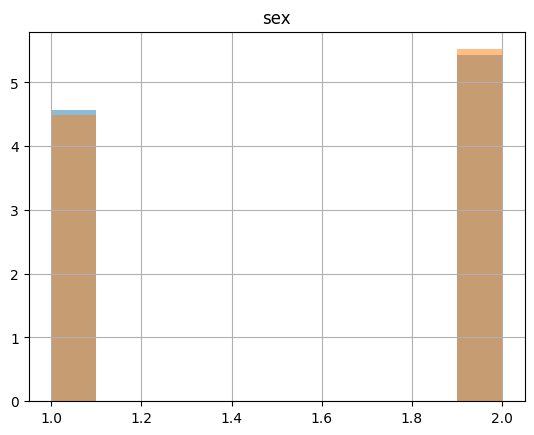

In [6]:
for covariate in covariates:
    data[covariate][W==0].hist(density=True, alpha=.5)
    data[covariate][W==1].hist(density=True,alpha=.5)
    plt.title(covariate)
    plt.show()   


So far, we have estimated an Average Treatment Effect in the randomized setting. 

Next, we'll modify the data in order to impose covariate imbalance, and look at methods for estimating causal treatment effects in the non-randomized (observational) setting. 

In [7]:
# Probabilistically dropping observations in a manner that depends on x

# copying old dataset, just in case
data_exp = data.copy()
data.shape

# defining the group that we will be dropped with some high probability
grp = ((data.w == 1) & ((data.age > 45) | (data.polviews < 5) )) | \
        ((data.w == 0) &  # if untreated AND
        (
            (data.age < 45) |   # belongs a younger group OR
            (data.polviews > 4)  # more liberal
        )) 



grp.sum()

# Individuals in the group above have a small chance of being kept in the sample
prob = grp.apply(lambda x: 0.15 if x == True else 0.85 ).tolist()
keep_idx = list( map( bool, [ np.random.binomial( 1 , p , data.shape[0] )[0] for p in prob ] )  )

# Dropping
data = data.loc[ keep_idx , : ].copy()

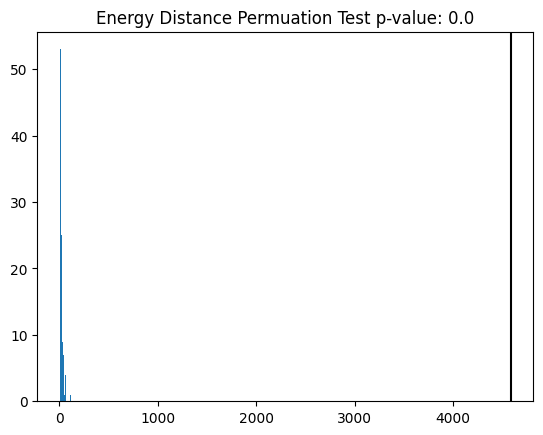

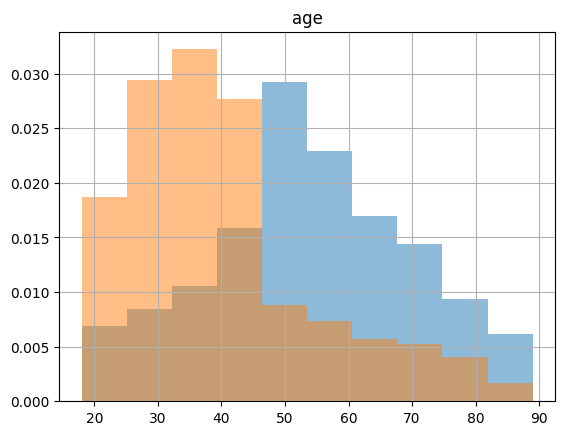

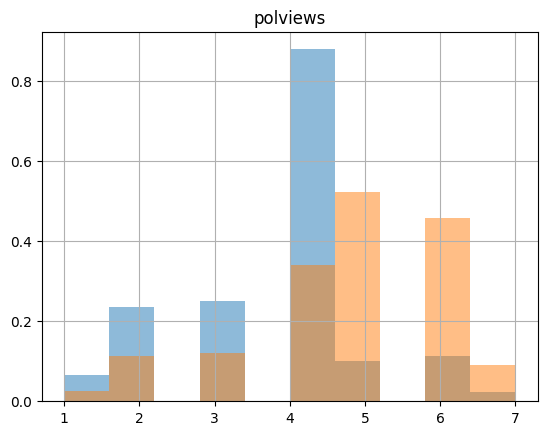

In [8]:
X_obs = data.loc[:,covariates].copy()
W_obs = data.loc[:,treatment].copy()
Y_obs = data.loc[:,outcome].copy()

num_perm=100
num_subsample=2000

n0_temp = sum(W_obs[:num_subsample]==0)
n1_temp=sum(W_obs[:num_subsample]==1)

#Calculate Distance matrix (for first 2000 entries)
D = squareform(pdist(X_obs[:num_subsample]))

#Calculate Observered Energy Distance between samples
E_obs = (n0_temp*n1_temp)/(n0_temp+n1_temp) * ( 2*(np.sum(D[W_obs[:num_subsample]==1][:,W_obs[:num_subsample]==0])/(n0_temp*n1_temp)) - (np.sum(D[W_obs[:num_subsample]==0][:,W_obs[:num_subsample]==0])/np.square(n0_temp)) - (np.sum(D[W_obs[:num_subsample]==1][:,W_obs[:num_subsample]==1])/np.square(n1_temp)))

E_permutations = np.zeros(num_perm)

#Sample from Distribution of Statistic
for i in range(num_perm):
    permutation = np.random.choice(num_subsample,num_subsample,replace=False)
    D_permute = D[permutation][:,permutation]
    E_permutations[i] = (n0_temp*n1_temp)/(n0_temp+n1_temp) *  (2*(np.sum(D_permute[W_obs[:num_subsample]==1][:,W_obs[:num_subsample]==0])/(n0_temp*n1_temp)) - (np.sum(D_permute[W_obs[:num_subsample]==0][:,W_obs[:num_subsample]==0])/np.square(n0_temp)) - (np.sum(D_permute[W_obs[:num_subsample]==1][:,W_obs[:num_subsample]==1])/np.square(n1_temp)))

plt.hist(E_permutations)
plt.axvline(E_obs,c='black')
plt.title("Energy Distance Permuation Test p-value: "+str(np.mean(E_obs<=E_permutations)))
plt.show()

for covariate in covariates[:2]:
    data[covariate][W==0].hist(density=True, alpha=.5)
    data[covariate][W==1].hist(density=True,alpha=.5)
    plt.title(covariate)
    plt.show()  

The covariates are extremely imbalanced, as can be seen clearly in the histograms. 

Thus, if we were to directly calculate a treatment effect, it would not be reasonable to infer that the observed difference was due to treatment, because "all else is (not) equal". The effects of the covariates are __confounded__ with the effect of the treatment.

Next, we'll look at methods where, under the __Potential Outcomes__ model, we can still reasonably infer causal effects of treatment. Note, because the original data was a randomized experiment, we can actually check the quality of our estimates.

<font size="5"> Direct Estimation </font>

The first approach we'll consider is to directly estimate the unobserved potential outcomes. (Specifically, we use a 'T-learner', as described in [Künzel, Sekhon, Bickel, Yu (2019)](https://arxiv.org/abs/1706.03461))

1)
Fit a regression model: $E[Y|X,W]$ 

2)
Predict both potential outcomes for each subject using the model: $\hat{Y}_i(1) = E[Y_i|X_i,1]$ and $\hat{Y}_i(0) = E[Y_i|X_i,0]$

3)
Calculate the Treatment effect on the estimated potential outcomes: $\hat{\tau}_{DM} = E[\hat{Y}_i(1) - \hat{Y}_i(0)]$. 


In [9]:
# Do not use! We'll see a better estimator below.

# Fitting some model of E[Y|X,W]
model = smf.ols("y ~ bs(age, df = 3) * w + bs(polviews, df = 3) * w + bs(income, df = 3) * w + bs(educ, df = 3) * w + bs(marital, df = 3) * w + bs(sex, df = 3) * w", data).fit()
data_aux = data.copy()

# Predicting E[Y|X,W=w] for w in {0, 1}
data_1 = data_aux.copy()
data_1.loc[ : , treatment] = 1
data_0 = data_aux.copy()
data_0.loc[ : , treatment] = 0
muhat_treat = model.predict( data_1 ) 
muhat_ctrl = model.predict( data_0 )

# Averaging predictions and taking their difference
ate_est = muhat_treat.mean() - muhat_ctrl.mean()
print(ate_est)

-0.3482710801458918


<font size="5"> Inverse Propensity Weighted Estimation </font>

Next, we'll consider the Inverse Propensity Weight Estimator


1)
Estimate Propensity scores $\hat{e}(X_i)$ by regressing $W_i$ on $X_i$

2)
Compute IPW Estimator: $\hat{\tau}_{IPW} = E[Y_i \ \hat{e}(X_i)^{-1}|W_i =1] - E[Y_i \ (1 - \hat{e}(X_i))^{-1}|W_i =0]$. 


##TODO: Provide some intuition for IPW


In [10]:
#Code
from sklearn.linear_model import LogisticRegressionCV

fmla = "bs(age, df = 3) + bs(polviews, df = 3) + bs(income, df = 3) +  bs(educ, df = 3) + bs(marital, df = 3) + bs(sex, df = 3)"
W = data.loc[ : ,treatment]
Y = data.loc[ : ,outcome]
XX = np.asarray( patsy.dmatrix( fmla, data ) )

In [11]:
# Available in randomized settings and observational settings with unconfoundedness+overlap

# Estimate the propensity score e(X) via logistic regression using splines
logit = LogisticRegressionCV( cv= 10, 
                              penalty = 'l2', 
                              random_state = 0, 
                              solver = "newton-cg" ).fit(XX, W)

prob = logit.predict_proba( XX )

e_hat = np.apply_along_axis( np.max , 1 , prob ) 

In [12]:
ipw_full = Y/e_hat

tau_ipw = np.mean(ipw_full[W==1])-np.mean(ipw_full[W==0])

tau_ipw

-0.4078474109460456

<font size="5"> Augmented Inverse Propensity Weights <font>
    
Finally, we combine the two estimators. ~Double Robustness
    
    
$\hat{\tau}_{AIPW} :=  \frac{1}{n}\sum_{i=1}^n (\hat{\mu}_1(X_i) - \hat{\mu}_0(X_i))$ 
    
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ + \frac{W_i}{\hat{e}(X_i)} (Y_i - \hat{\mu}_1(X_i)) - \frac{(1 - W_i)}{(1 - \hat{e}(X_i))} (Y_i - \hat{\mu}_0(X_i))$

In [13]:
import econml
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.grf import CausalForest
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from sklearn.linear_model import MultiTaskLassoCV
# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.grf import RegressionForest
%matplotlib inline
import patsy

fmla = 'age+polviews+income+educ+marital+sex'
desc = patsy.ModelDesc.from_formula(fmla)
desc.describe()
matrix = patsy.dmatrix(fmla, data, return_type = "dataframe")

T = data.loc[ : ,"w"]
Y = data.loc[ : ,"y"]
X = matrix
W = None 

# Estimate a causal forest.
est2 = CausalForest(n_estimators=100, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)

est2.fit(X, T, Y)


CausalForest(max_depth=50, random_state=123)

In [14]:
np.mean(est2.predict(X=X))

-0.34398701114843105

In [15]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

mean_mdl = RandomForestClassifier(max_depth=50, random_state=123, n_estimators=100)
propensity_mdl = LogisticRegressionCV( cv= 10, penalty = 'l2', random_state = 0, solver = "newton-cg" )

mu_hat_0 = mean_mdl.fit(X[T==0],Y[T==0]).predict(X).flatten()
mu_hat_1 = mean_mdl.fit(X[T==1],Y[T==1]).predict(X).flatten()

e_hat = propensity_mdl.fit(X, T).predict_proba(X)[:,0]

ate_aipw_est = (mu_hat_1 - mu_hat_0) + ((T/e_hat)*(Y-mu_hat_1) - ((1-T)/(1-e_hat))*(Y-mu_hat_0))

print(np.mean(ate_aipw_est))

-0.35878301141219016


In [16]:
def aipw_est(X,Y,W, mean_mdl, propensity_mdl):
    
    #learner
    mu_hat_0 = mean_mdl.fit(X[W==0],Y[W==0]).predict(X).flatten()
    mu_hat_1 = mean_mdl.fit(X[W==1],Y[W==1]).predict(X).flatten()
    
    #Estimated propensity score function
    e_hat = propensity_mdl.fit(X, W).predict_proba(X)[:,0]
    
    aipw_scores = (mu_hat_1 - mu_hat_0) + ((W/e_hat)*(Y-mu_hat_1) - ((1-W)/(1-e_hat))*(Y-mu_hat_0))
    
    #Augmented Inverse Propensity Weighted Estimator
    ate_aipw_est = np.mean( aipw_scores )
    ate_se = np.std(aipw_scores) / np.sqrt(len(aipw_scores))
    ate_tstat = ate_est/ate_se
    ate_pvalue = 2*norm.cdf(1-abs(ate_est/ate_se))
    
    return pd.DataFrame({'estimate': [ate_aipw_est],
                        'std_error': [ate_se],
                        't_stat': [ate_tstat],
                        'pvalue': [ ate_pvalue]})

In [17]:
ate_aipw_est = aipw_est(X, Y, T, mean_mdl, propensity_mdl)

In [18]:
ate_aipw_est

,estimate,std_error,t_stat,pvalue
0,-0.358783,0.008964,-38.850488,0.0


<font size='5'> Treatment Effect Estimation under Domain Shift with Optimal Transport<font>

In [19]:
import ot

class ot_potential_outcome_estimator:
    
    def __init__(self):
        pass
        
    def fit(self,X,Y,W):
        X0 = X[W==0].copy().values
        X1 = X[W==1].copy().values

        Y0 = Y[W==0].copy().values
        Y1 = Y[W==1].copy().values
        
        n0 = sum(W==0)
        n1 = sum(W==1)

        a = np.ones(n0)/n0
        b = np.ones(n1)/n1

        M = ot.dist(X0,X1)

        Pi = ot.emd(a,b,M)

        self.mu_1_hat = np.diag(1/a)@(Pi@Y1)
        self.mu_0_hat = np.diag(1/b)@(Pi.T@Y0)

In [20]:
# Reset data
data = pd.read_pickle("gss.pkl")

Y = data.loc[:,outcome].copy()
W = data.loc[:,treatment].copy()
X = data.loc[:,covariates].copy()


Here, we translate the 

In [21]:
X[W==1]=X[W==1]+(np.random.rand(6)-.5)*1

ot_mean_model = ot_potential_outcome_estimator()
ot_mean_model.fit(X,Y,W)

mu_0_hat,mu_1_hat = ot_mean_model.mu_0_hat,ot_mean_model.mu_1_hat

print(np.mean(Y[W==1]-mu_0_hat))
print(np.mean(mu_1_hat-Y[W==0]))

-0.3471155447921709
-0.3471155447921709


In [22]:
aipw_est(X,Y,W,mean_mdl,propensity_mdl)

,estimate,std_error,t_stat,pvalue
0,-0.33157,0.004001,-87.055322,0.0
